In [1]:
#General import
import pandas as pd
import janitor as jn
import pandas_profiling
import numpy as np
import xgboost as xgb
import os
import pydotplus

#sklearn import
from sklearn import ensemble,preprocessing,tree, impute
from sklearn.metrics import average_precision_score,auc, confusion_matrix,roc_auc_score,roc_curve, precision_score, confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,KFold, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#missingno import
import missingno as msno

#mlxtend import
from mlxtend.classifier import StackingClassifier

##Yellowbirck import
from yellowbrick.classifier import DiscriminationThreshold,ClassPredictionError,ClassBalance,PrecisionRecallCurve,ConfusionMatrix, ROCAUC, ClassificationReport
from yellowbrick.features import JointPlotVisualizer,Rank2D, RadViz
from yellowbrick.model_selection import LearningCurve, FeatureImportances, ValidationCurve

from io import StringIO

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image


/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Get train and test absolute path
CURRENT_DIR = os.getcwd()
DATA_DIR = 'data'
TRAIN_FILENAME ='train.csv'
TEST_FILENAME = 'test.csv'
train_path = os.path.join(CURRENT_DIR,DATA_DIR,TRAIN_FILENAME)
test_path = os.path.join(CURRENT_DIR,DATA_DIR,TEST_FILENAME)

In [3]:
#Load train.csv and test.csv as pandas Dataframe
train = pd.read_csv(train_path, index_col='PassengerId')
test = pd.read_csv(test_path, index_col='PassengerId')

In [4]:
train = jn.clean_names(train)
test = jn.clean_names(test)

In [5]:
y = train.survived

In [6]:
#Encode Categorical features and removed unecessary ones
cat_df= pd.get_dummies(train[["sex","embarked"]],drop_first=True)
X = pd.concat([train,cat_df], axis = 1)
X = X.drop(columns=["survived","name","ticket","cabin","embarked","sex"])

In [9]:
#Impute training
num_cols = ['pclass','age','sibsp','parch','fare','sex_male']
imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(X[num_cols])
X.loc[:,num_cols] = imputed

In [10]:
from sklearn.cluster import KMeans
X_std = preprocessing.StandardScaler().fit_transform(X)
km = KMeans(2, random_state=42)
km.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [11]:
X_km = km.predict(X)

In [12]:
X_km

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
inertias =[]
sizes = range(1,10)
for k in sizes:
    k2 = KMeans(n_clusters=k,random_state=42)
    k2.fit(X_std)
    inertias.append(k2.inertia_)
fig,ax = plt.subplots(figsize=(6,4))
pd.Series(inertias, index = sizes).plot(ax=ax)
ax.set_xlabel("K")
ax.set_ylabel("Inertia")

In [ ]:
from sklearn import metrics
inertias = []
sils = []
chs = []
dbs= []
sizes = range(2,13)
for k in sizes: 
    k2 = KMeans(n_clusters=k,random_state=42)
    k2.fit(X_std)
    inertias.append(k2.inertia_)
    sils.append(metrics.silhouette_score(X_std,k2.labels_))
    chs.append(metrics.calinski_harabasz_score(X_std,k2.labels_))
    dbs.append(metrics.davies_bouldin_score(X_std,k2.labels_))


In [ ]:
fig,ax = plt.subplots(figsize=(6,4))
pd.DataFrame({"inertia":inertias,
             "silhouette":sils,
             "calinski":chs,
             "davis":dbs,
             },index=sizes).plot(ax=ax,subplots=True, layout = (2,2))

In [ ]:
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
fig,axes = plt.subplots(2,2,figsize=(12,8))
axes = axes.reshape(4)
for i, k in enumerate(range(2,6)):
    ax = axes[i]
    sil = SilhouetteVisualizer(KMeans(n_clusters=k,random_state=42),
                              ax=ax)
    sil.fit(X_std)
    sil.finalize()
    ax.set_xlim(-0.2,0.8)
plt.tight_layout()

In [ ]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6,4))
dend = hierarchy.dendrogram(hierarchy.linkage(X_std, method= "ward"))

In [ ]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6,4))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X_std, method= "ward"),
    truncate_mode="lastp",
    p=20,
    show_contracted=True)

In [ ]:
from sklearn.cluster import (AgglomerativeClustering)
ag = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
ag.fit(X_std)

In [ ]:
#Understanding cluster
km = KMeans(n_clusters=2)
km.fit(X_std)
labels = km.predict(X_std)
X.assign(cluster=labels, survived = y).groupby("cluster").agg(["mean","var","max"]).T

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
X.assign(cluster=labels, survived = y).groupby("cluster").mean().T.plot.bar(ax=ax)

Text(0, 0.5, 'Inertia')

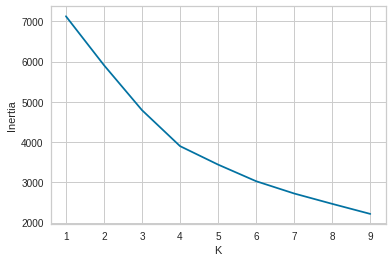

In [22]:
from sklearn import metrics
inertias = []
sils = []
chs = []
dbs= []
sizes = range(2,13)
for k in sizes: 
    k2 = KMeans(n_clusters=k,random_state=42)
    k2.fit(X_std)
    inertias.append(k2.inertia_)
    sils.append(metrics.silhouette_score(X_std,k2.labels_))
    chs.append(metrics.calinski_harabasz_score(X_std,k2.labels_))
    dbs.append(metrics.davies_bouldin_score(X_std,k2.labels_))


/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcee1029940>,
      dtype=object)

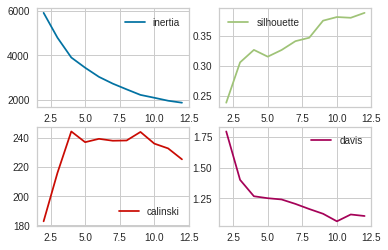

In [25]:
fig,ax = plt.subplots(figsize=(6,4))
pd.DataFrame({"inertia":inertias,
             "silhouette":sils,
             "calinski":chs,
             "davis":dbs,
             },index=sizes).plot(ax=ax,subplots=True, layout = (2,2))

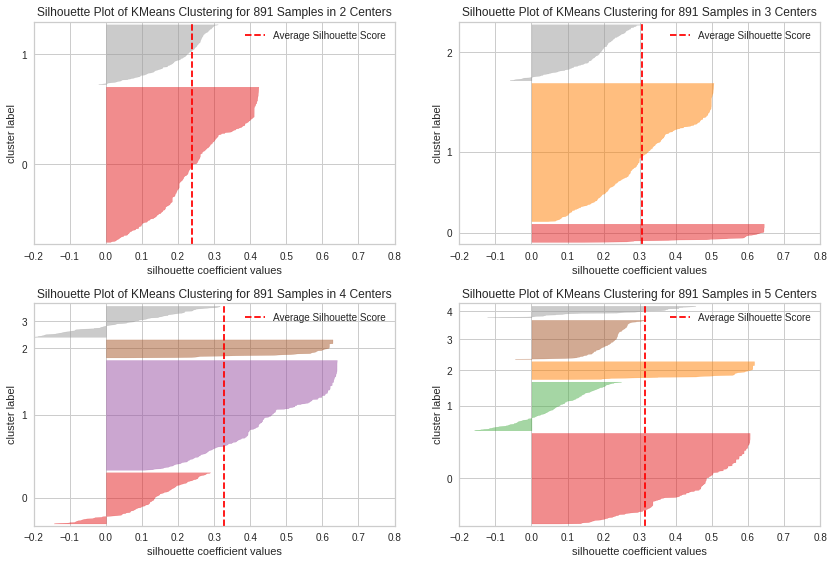

In [27]:
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
fig,axes = plt.subplots(2,2,figsize=(12,8))
axes = axes.reshape(4)
for i, k in enumerate(range(2,6)):
    ax = axes[i]
    sil = SilhouetteVisualizer(KMeans(n_clusters=k,random_state=42),
                              ax=ax)
    sil.fit(X_std)
    sil.finalize()
    ax.set_xlim(-0.2,0.8)
plt.tight_layout()

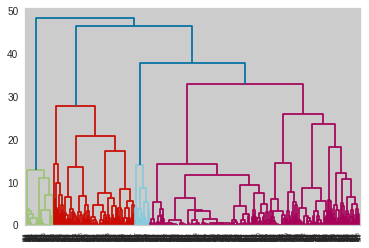

In [28]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6,4))
dend = hierarchy.dendrogram(hierarchy.linkage(X_std, method= "ward"))

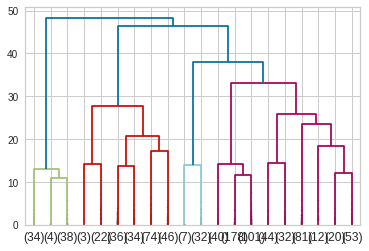

In [29]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6,4))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X_std, method= "ward"),
    truncate_mode="lastp",
    p=20,
    show_contracted=True)

In [31]:
from sklearn.cluster import (AgglomerativeClustering)
ag = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
ag.fit(X_std)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4)

In [34]:
#Understanding cluster
km = KMeans(n_clusters=2)
km.fit(X_std)
labels = km.predict(X_std)
X.assign(cluster=labels, survived = y).groupby("cluster").agg(["mean","var","max"]).T

cluster                    0           1
pclass     mean     1.129032    2.763608
           var      0.112838    0.180792
           max      2.000000    3.000000
age        mean    39.957218   25.180894
           var    190.252880  123.743100
           max     80.000000   74.000000
sibsp      mean     0.403226    0.569207
           var      0.363066    1.538427
           max      3.000000    8.000000
parch      mean     0.350806    0.393468
           var      0.479675    0.715658
           max      4.000000    6.000000
fare       mean    76.047530   15.294186
           var   5820.912093  154.912233
           max    512.329200   73.500000
sex_male   mean     0.560484    0.681182
           var      0.247339    0.217511
           max      1.000000    1.000000
embarked_Q mean     0.012097    0.115086
           var      0.011999    0.101999
           max      1.000000    1.000000
embarked_S mean     0.637097    0.755832
           var      0.232141    0.184837
           max      1.000000    1.000000
survived   mean     0.604839    0.298600
           var      0.239976    0.209764
           max      1.000000    1.000000

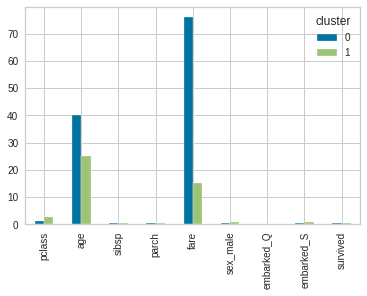

In [35]:
fig, ax = plt.subplots(figsize=(6,4))
X.assign(cluster=labels, survived = y).groupby("cluster").mean().T.plot.bar(ax=ax)